### Import

In [1]:
import argparse
import os
import time

import dgl

import model
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset
# from input_data import load_data
from preprocess import (
    mask_test_edges,
    mask_test_edges_dgl,
    preprocess_graph,
    sparse_to_tuple,
)
from sklearn.metrics import average_precision_score, roc_auc_score

In [2]:
from tqdm import tqdm
import pandas as pd
import networkx as nx
import numpy as np

from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
import hdbscan

%load_ext autotime

time: 175 µs (started: 2023-05-17 17:53:56 -05:00)


In [3]:
import sys
sys.path.append("../../")

from Utils_TM.utils import *

/home/ealvarez/miniconda3/envs/Conda_vgae_3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_vgae_3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_vgae_3.10

time: 3.41 s (started: 2023-05-17 17:54:00 -05:00)


In [4]:
torch.manual_seed(42)
np.random.seed(42)

time: 2.98 ms (started: 2023-05-17 17:54:07 -05:00)


### Test VGAE

In [53]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

parser = argparse.ArgumentParser(description="Variant Graph Auto Encoder")
parser.add_argument(
    "--learning_rate", type=float, default=0.01, help="Initial learning rate."
)
parser.add_argument(
    "--epochs", "-e", type=int, default=200, help="Number of epochs to train."
)
parser.add_argument(
    "--hidden1",
    "-h1",
    type=int,
    default=32,
    help="Number of units in hidden layer 1.",
)
parser.add_argument(
    "--hidden2",
    "-h2",
    type=int,
    default=16,
    help="Number of units in hidden layer 2.",
)
parser.add_argument(
    "--datasrc",
    "-s",
    type=str,
    default="dgl",
    help="Dataset download from dgl Dataset or website.",
)
parser.add_argument(
    "--dataset", "-d", type=str, default="cora", help="Dataset string."
)
parser.add_argument("--gpu_id", type=int, default=0, help="GPU id to use.")
args = parser.parse_args("")

time: 3.44 ms (started: 2023-05-17 13:10:43 -05:00)


In [54]:
# check device
device = torch.device(
    "cuda:{}".format(args.gpu_id) if torch.cuda.is_available() else "cpu"
)
device = "cpu"
device
# roc_means = []
# ap_means = []

'cpu'

time: 3.96 ms (started: 2023-05-17 13:10:46 -05:00)


In [55]:
def compute_loss_para(adj):
    pos_weight = (adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = (
        adj.shape[0]
        * adj.shape[0]
        / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    )
    weight_mask = adj.view(-1) == 1
    weight_tensor = torch.ones(weight_mask.size(0)).to(device)
    weight_tensor[weight_mask] = pos_weight
    return weight_tensor, norm


def get_acc(adj_rec, adj_label):
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy


def get_scores(edges_pos, edges_neg, adj_rec):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    adj_rec = adj_rec.cpu()
    # Predict on test set of edges
    preds = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]].item()))

    preds_neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]].data))

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

time: 990 µs (started: 2023-05-17 13:10:48 -05:00)


In [56]:
# Test using custom dataset
import urllib.request

import pandas as pd

urllib.request.urlretrieve(
    "https://data.dgl.ai/tutorial/dataset/members.csv", "./members.csv"
)
urllib.request.urlretrieve(
    "https://data.dgl.ai/tutorial/dataset/interactions.csv",
    "./interactions.csv",
)

members = pd.read_csv("./members.csv")
members.head()

interactions = pd.read_csv("./interactions.csv")
interactions.head()


import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset

class KarateClubDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="karate_club")

    def process(self):
        nodes_data = pd.read_csv("./members.csv")
        edges_data = pd.read_csv("./interactions.csv")
        node_features = torch.from_numpy(nodes_data["Age"].to_numpy())
        node_labels = torch.from_numpy(
            nodes_data["Club"].astype("category").cat.codes.to_numpy()
        )
        edge_features = torch.from_numpy(edges_data["Weight"].to_numpy())
        node_features = node_features.to(torch.float32)
        node_features = torch.reshape(node_features, (-1, 1))

        edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
        edges_dst = torch.from_numpy(edges_data["Dst"].to_numpy())

        self.graph = dgl.graph(
            (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
        )
        self.graph.ndata["feat"] = node_features
        self.graph.ndata["label"] = node_labels
        self.graph.edata["weight"] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train : n_train + n_val] = True
        test_mask[n_train + n_val :] = True
        self.graph.ndata["train_mask"] = train_mask
        self.graph.ndata["val_mask"] = val_mask
        self.graph.ndata["test_mask"] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1


dataset = KarateClubDataset()
graph = dataset[0]

print(graph)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})
time: 273 ms (started: 2023-05-17 13:10:58 -05:00)


In [74]:
# Load from DGL dataset
""" if args.dataset == "cora":
    dataset = CoraGraphDataset(reverse_edge=False)
elif args.dataset == "citeseer":
    dataset = CiteseerGraphDataset(reverse_edge=False)
elif args.dataset == "pubmed":
    dataset = PubmedGraphDataset(reverse_edge=False)
else:
    raise NotImplementedError """

""" from dgl.data import load_data
dataset = load_data(args) """

dataset = KarateClubDataset()

graph = dataset[0]
print(graph)

# Extract node features
feats = graph.ndata.pop("feat").to(device)
# print(device, feats)
in_dim = feats.shape[-1]
print(in_dim)
# generate input
adj_orig = graph.adj_external().to_dense()

# build test set with 10% positive links
(
    train_edge_idx,
    _,
    _,
    _,
    _,
) = mask_test_edges_dgl(graph, adj_orig)

graph = graph.to(device)

# create train graph
train_edge_idx = torch.tensor(train_edge_idx).to(device)
train_graph = dgl.edge_subgraph(graph, train_edge_idx, relabel_nodes=False)
train_graph = train_graph.to(device)
adj = train_graph.adj_external().to_dense().to(device)

# compute loss parameters
weight_tensor, norm = compute_loss_para(adj)
print(weight_tensor)

# create model
vgae_model = model.VGAEModel(in_dim, args.hidden1, args.hidden2)
vgae_model = vgae_model.to(device)

# create training component
optimizer = torch.optim.Adam(vgae_model.parameters(), lr=args.learning_rate)
print(
    "Total Parameters:",
    sum([p.nelement() for p in vgae_model.parameters()]),
)

# create training epoch
for epoch in range(args.epochs):
    t = time.time()

    # Training and validation using a full graph
    vgae_model.train()

    logits = vgae_model.forward(graph, feats)
    print(0, len(logits), logits)
    # compute loss
    print(1, len(logits.view(-1)), logits.view(-1))
    print(2, len(adj.view(-1)), adj.view(-1))
    print(3, len(weight_tensor), weight_tensor)
    loss = norm * F.binary_cross_entropy(
        logits.view(-1), adj.view(-1), weight=weight_tensor
    )
    kl_divergence = (
        0.5
        / logits.size(0)
        * (
            1
            + 2 * vgae_model.log_std
            - vgae_model.mean**2
            - torch.exp(vgae_model.log_std) ** 2
        )
        .sum(1)
        .mean()
    )
    loss -= kl_divergence

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # train_acc = get_acc(logits, adj)

    # val_roc, val_ap = get_scores(val_edges, val_edges_false, logits)

    # Print out performance
    """ print(
        "Epoch:",
        "%04d" % (epoch + 1),
        "train_loss=",
        "{:.5f}".format(loss.item()),
        "train_acc=",
        "{:.5f}".format(train_acc),
        "val_roc=",
        "{:.5f}".format(val_roc),
        "val_ap=",
        "{:.5f}".format(val_ap),
        "time=",
        "{:.5f}".format(time.time() - t),
    ) """

""" test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)
# roc_means.append(test_roc)
# ap_means.append(test_ap)
print(
    "End of training!",
    "test_roc=",
    "{:.5f}".format(test_roc),
    "test_ap=",
    "{:.5f}".format(test_ap),
) """

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})
1
tensor([1.0000, 7.6269, 7.6269,  ..., 7.6269, 7.6269, 1.0000])
Total Parameters: 1120
0 34 tensor([[1., 0., 1.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 0., 1.,  ..., 1., 1., 0.],
        [1., 0., 1.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.]], grad_fn=<SigmoidBackward0>)
1 1156 tensor([1., 0., 1.,  ..., 0., 0., 1.], grad_fn=<ViewBackward0>)
2 1156 tensor([0., 1., 1.,  ..., 1., 1., 0.])
3 1156 tensor([1.0000, 7.6269, 7.6269,  ..., 7.6269, 7.6269, 1.0000])
0 34 tensor([[1., 0., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ...

/home/ealvarez/miniconda3/envs/Conda_vgae_3.10/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


0 34 tensor([[0.9885, 0.9760, 0.9809,  ..., 0.9771, 0.9851, 0.9940],
        [0.9760, 0.9911, 0.9630,  ..., 0.9603, 0.9846, 0.9929],
        [0.9809, 0.9630, 0.9873,  ..., 0.9698, 0.9806, 0.9955],
        ...,
        [0.9771, 0.9603, 0.9698,  ..., 0.9683, 0.9745, 0.9906],
        [0.9851, 0.9846, 0.9806,  ..., 0.9745, 0.9924, 0.9969],
        [0.9940, 0.9929, 0.9955,  ..., 0.9906, 0.9969, 0.9995]],
       grad_fn=<SigmoidBackward0>)
1 1156 tensor([0.9885, 0.9760, 0.9809,  ..., 0.9906, 0.9969, 0.9995],
       grad_fn=<ViewBackward0>)
2 1156 tensor([0., 1., 1.,  ..., 1., 1., 0.])
3 1156 tensor([1.0000, 7.6269, 7.6269,  ..., 7.6269, 7.6269, 1.0000])
0 34 tensor([[0.9875, 0.9359, 0.9178,  ..., 0.9555, 0.9659, 0.9728],
        [0.9359, 0.9401, 0.8066,  ..., 0.9170, 0.8826, 0.9028],
        [0.9178, 0.8066, 0.8533,  ..., 0.8688, 0.8849, 0.8824],
        ...,
        [0.9555, 0.9170, 0.8688,  ..., 0.9583, 0.9667, 0.8980],
        [0.9659, 0.8826, 0.8849,  ..., 0.9667, 0.9944, 0.9101],
      

' test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)\n# roc_means.append(test_roc)\n# ap_means.append(test_ap)\nprint(\n    "End of training!",\n    "test_roc=",\n    "{:.5f}".format(test_roc),\n    "test_ap=",\n    "{:.5f}".format(test_ap),\n) '

time: 518 ms (started: 2023-05-17 13:22:42 -05:00)


In [35]:
embeds = vgae_model.encoder(graph, feats)
embeds = embeds.cpu().detach()

df_node_embeddings = pd.DataFrame(data=embeds)
df_node_embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.139144,1.208450,0.315557,0.248189,0.019091,-0.221188,0.034454,-1.469646,-4270.980957,0.097637,-1.582336,0.523223,-33.831459,0.686221,0.878276,-0.069842
1,0.906625,1.049310,-0.509537,-0.213015,-0.110699,0.095929,0.050023,-0.195941,274.805420,0.066242,-0.922338,-0.658369,-10.867623,0.192224,1.832332,-0.983147
2,-0.626009,2.318367,-0.989996,-0.228966,-0.106781,0.985871,0.017786,-0.153947,676.177734,0.049665,0.259802,2.012964,146.902832,2.246964,0.515832,-0.642008
3,1.248434,-0.971160,-1.712178,0.147631,0.968449,-1.411940,-0.038003,0.638183,94.134521,0.029495,-0.600931,0.527011,-8.539551,0.808930,0.390319,0.644491
4,-1.398453,1.555800,-1.807487,-0.101588,1.114823,-0.101351,-0.105721,-1.843863,-4.326557,-0.024784,-1.040808,-0.716520,-8.120500,1.815981,0.969883,-0.510687
5,0.288343,0.154124,0.996816,-0.226898,0.442810,-0.421679,0.037222,0.242363,393.627472,0.057406,-0.278794,0.588310,13.294950,0.897254,-0.514641,0.308437
6,-1.421278,1.917539,0.641149,-0.966127,0.492856,-0.033160,-0.001910,-0.017778,241.202805,0.048109,2.066311,0.587181,36.401329,0.362600,1.695789,0.171424
7,0.230507,-0.241090,1.816168,1.361705,1.392772,2.171232,0.050183,0.564782,-21.273424,-0.004524,0.688850,1.294105,1.107212,0.106863,2.851988,-0.837431
8,-0.822779,1.667708,-1.399089,1.452259,-0.771158,0.990015,0.044159,-1.004639,208.569717,0.003051,-1.287567,-1.272336,-2.661533,0.552030,0.320869,-0.463326
9,-0.552278,0.805030,0.240049,0.733674,0.907990,0.181582,-0.129209,0.379017,-47.166336,-0.025401,-0.069718,-0.229809,-11.113106,-0.852294,0.260836,-1.473421


time: 36.5 ms (started: 2023-05-17 12:51:45 -05:00)


---

### 1. Data preprocessing

In [102]:
dir = "/home/ealvarez/Project/GNN_Filter"

time: 519 µs (started: 2023-05-18 09:41:59 -05:00)


In [101]:
# Read dataset

group = [("WT", 5), ("zwf1^", 3), ("pck1^", 2)]
group = group[2]
print(group)

('pck1^', 2)
time: 1.15 ms (started: 2023-05-18 09:41:53 -05:00)


In [32]:
# Load dataset Groups
df1 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir, "int1"), delimiter="|")
df2 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir, "int2"), delimiter="|")
df3 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir, "int3"), delimiter="|")
df4 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir, "int4"), delimiter="|")
# df5_ = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int5"), delimiter="|")

""" df1 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities1"), delimiter="|")
df2 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities2"), delimiter="|")
df3 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities3"), delimiter="|")
df4 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities4"), delimiter="|")
df5_ = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities5"), delimiter="|") """

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
# print(df5_.shape)

(6245, 102)
(6245, 72)
(6245, 97)
(6245, 137)
time: 292 ms (started: 2023-05-16 15:08:36 -05:00)


In [33]:
# concat
# df_join_raw = pd.concat([df1.iloc[:,1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:], df5.iloc[:, 2:]], axis=1)
df_join_raw = pd.concat([df1.iloc[:, 1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:]], axis=1)
df_join_raw.set_index("ionMz", inplace=True)

print(df_join_raw.shape)
df_join_raw

(6245, 400)


,0001 / zwf1^ 3.4,0002 / zwf1^ 3.4,0003 / zwf1^ 3.4,0004 / zwf1^ 3.4,0005 / zwf1^ 3.4,0006 / zwf1^ 3.4,0007 / zwf1^ 3.4,0008 / zwf1^ 3.4,0009 / zwf1^ 3.4,0010 / zwf1^ 3.4,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1,47,508,360,675,232,59,345,346,504,...,45,817,32,307,410,716,228,187,361,952
59.0137,53182,57902,51861,62812,54291,54395,59054,52547,57544,63538,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2151,2102,2334,2864,2393,2246,2331,1954,2310,2528,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,83,174,366,1134,693,464,235,479,443,691,...,225,349,185,429,186,278,364,368,115,887
59.0453,1,1,51,642,493,143,11,227,160,154,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2470,2435,2465,2727,2773,2157,2168,2623,2256,2636,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,3366,3241,2909,3469,3538,3010,3031,2872,2709,3601,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,2818,2335,1807,1679,2222,2070,2158,1835,2087,2784,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433


time: 38.6 ms (started: 2023-05-16 15:08:38 -05:00)


In [34]:
# get WT groud
df_wt = df_join_raw.filter(regex="WT", axis=1)

print(df_wt.shape)
df_wt

(6245, 200)


,0071 / WT 2.2,0072 / WT 2.2,0073 / WT 2.2,0074 / WT 2.2,0075 / WT 2.2,0076 / WT 2.2,0077 / WT 2.2,0078 / WT 2.2,0079 / WT 2.2,0080 / WT 2.2,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,528,1,378,438,530,250,662,431,305,334,...,45,817,32,307,410,716,228,187,361,952
59.0137,56523,24625,78586,76559,67449,74919,88152,99718,86001,93962,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2290,927,3149,3038,2774,3419,3911,3820,3374,3746,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,320,195,1137,642,588,799,602,606,768,372,...,225,349,185,429,186,278,364,368,115,887
59.0453,196,59,555,405,234,413,46,148,95,25,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2050,1415,3851,2285,2038,3089,2737,2788,1819,2600,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,2681,1984,3570,2169,2479,2668,3033,3271,2264,2411,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,1516,1307,2299,2363,2877,1436,1771,2326,1629,2740,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433


time: 26.8 ms (started: 2023-05-16 15:08:40 -05:00)


In [35]:
# get ZW groud
df_zw = df_join_raw.filter(like="zwf1^")

print(df_zw.shape)
df_zw

(6245, 120)


,0001 / zwf1^ 3.4,0002 / zwf1^ 3.4,0003 / zwf1^ 3.4,0004 / zwf1^ 3.4,0005 / zwf1^ 3.4,0006 / zwf1^ 3.4,0007 / zwf1^ 3.4,0008 / zwf1^ 3.4,0009 / zwf1^ 3.4,0010 / zwf1^ 3.4,...,0861 / zwf1^ 1.4,0862 / zwf1^ 1.4,0863 / zwf1^ 1.4,0864 / zwf1^ 1.4,0865 / zwf1^ 1.4,0866 / zwf1^ 1.4,0867 / zwf1^ 1.4,0868 / zwf1^ 1.4,0869 / zwf1^ 1.4,0870 / zwf1^ 1.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1,47,508,360,675,232,59,345,346,504,...,344,790,851,372,899,752,54,254,145,1236
59.0137,53182,57902,51861,62812,54291,54395,59054,52547,57544,63538,...,134377,133636,129520,122223,133150,129628,127563,116371,114443,118647
59.0291,2151,2102,2334,2864,2393,2246,2331,1954,2310,2528,...,5207,5676,5416,5091,5594,5638,5234,4746,4308,5475
59.0370,83,174,366,1134,693,464,235,479,443,691,...,939,946,1195,700,1071,1302,993,857,412,1348
59.0453,1,1,51,642,493,143,11,227,160,154,...,225,168,398,84,76,516,127,351,1,753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2470,2435,2465,2727,2773,2157,2168,2623,2256,2636,...,1647,3001,2639,2850,2716,2415,2060,2886,2558,2891
996.7096,3366,3241,2909,3469,3538,3010,3031,2872,2709,3601,...,2002,3333,2695,2343,2433,2471,2424,2671,2323,2457
997.5542,2818,2335,1807,1679,2222,2070,2158,1835,2087,2784,...,2782,2553,2499,1393,2354,2002,2307,2151,2031,1425


time: 27.9 ms (started: 2023-05-16 15:08:43 -05:00)


In [36]:
# get pc groud
df_pc = df_join_raw.filter(like="pck1^")

print(df_pc.shape)
df_pc

(6245, 80)


,0011 / pck1^ 2.4,0012 / pck1^ 2.4,0013 / pck1^ 2.4,0014 / pck1^ 2.4,0015 / pck1^ 2.4,0016 / pck1^ 2.4,0017 / pck1^ 2.4,0018 / pck1^ 2.4,0019 / pck1^ 2.4,0020 / pck1^ 2.4,...,0881 / pck1^ 2.3,0882 / pck1^ 2.3,0883 / pck1^ 2.3,0884 / pck1^ 2.3,0885 / pck1^ 2.3,0886 / pck1^ 2.3,0887 / pck1^ 2.3,0888 / pck1^ 2.3,0889 / pck1^ 2.3,0890 / pck1^ 2.3
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,901,81,377,488,883,426,421,689,383,222,...,857,655,431,335,200,670,256,288,315,427
59.0137,33968,22565,36285,30275,34858,28558,36375,31684,25583,24293,...,59883,65860,65463,64715,52758,56120,60780,64502,62149,66849
59.0291,1947,945,2010,1776,1806,1549,2015,1494,1399,1029,...,2528,3118,2863,2896,2422,2483,2878,3035,2456,2964
59.0370,644,139,752,607,694,685,681,404,619,117,...,522,911,995,655,740,733,652,693,697,724
59.0453,139,78,352,414,373,388,376,353,345,134,...,181,459,429,155,321,257,342,135,315,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,1169,923,815,1219,638,1161,1461,1710,1224,947,...,1580,1340,1940,1714,1266,735,828,1709,978,1051
996.7096,1122,1767,1914,1748,1575,1599,1738,1701,2425,1651,...,1330,817,1456,1113,816,520,161,1229,596,447
997.5542,1135,1849,1313,819,1883,1296,964,1236,1117,711,...,1111,1401,467,2230,1664,1296,391,587,883,762


time: 30.5 ms (started: 2023-05-16 15:08:46 -05:00)


In [40]:
# Logarithm

if group[0] == "WT": # Unable this line when it's run by group
  df_join_raw = df_wt.copy()
elif group[0] == "zwf1^":
  df_join_raw = df_zw.copy()
elif group[0] == "pck1^":
  df_join_raw = df_pc.copy()

df_raw_log = df_join_raw.copy()
for column in df_join_raw.columns:
  df_raw_log[column] = np.log10(df_join_raw[column])

df_raw_log

/home/ealvarez/miniconda3/envs/Conda_vgae_3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,0011 / pck1^ 2.4,0012 / pck1^ 2.4,0013 / pck1^ 2.4,0014 / pck1^ 2.4,0015 / pck1^ 2.4,0016 / pck1^ 2.4,0017 / pck1^ 2.4,0018 / pck1^ 2.4,0019 / pck1^ 2.4,0020 / pck1^ 2.4,...,0881 / pck1^ 2.3,0882 / pck1^ 2.3,0883 / pck1^ 2.3,0884 / pck1^ 2.3,0885 / pck1^ 2.3,0886 / pck1^ 2.3,0887 / pck1^ 2.3,0888 / pck1^ 2.3,0889 / pck1^ 2.3,0890 / pck1^ 2.3
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,2.954725,1.908485,2.576341,2.688420,2.945961,2.629410,2.624282,2.838219,2.583199,2.346353,...,2.932981,2.816241,2.634477,2.525045,2.301030,2.826075,2.408240,2.459392,2.498311,2.630428
59.0137,4.531070,4.353435,4.559727,4.481084,4.542302,4.455728,4.560803,4.500840,4.407951,4.385481,...,4.777304,4.818622,4.815996,4.811005,4.722288,4.749118,4.783761,4.809573,4.793434,4.825095
59.0291,3.289366,2.975432,3.303196,3.249443,3.256718,3.190051,3.304275,3.174351,3.145818,3.012415,...,3.402777,3.493876,3.456821,3.461799,3.384174,3.394977,3.459091,3.482159,3.390228,3.471878
59.0370,2.808886,2.143015,2.876218,2.783189,2.841359,2.835691,2.833147,2.606381,2.791691,2.068186,...,2.717671,2.959518,2.997823,2.816241,2.869232,2.865104,2.814248,2.840733,2.843233,2.859739
59.0453,2.143015,1.892095,2.546543,2.617000,2.571709,2.588832,2.575188,2.547775,2.537819,2.127105,...,2.257679,2.661813,2.632457,2.190332,2.506505,2.409933,2.534026,2.130334,2.498311,2.618048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,3.067815,2.965202,2.911158,3.086004,2.804821,3.064832,3.164650,3.232996,3.087781,2.976350,...,3.198657,3.127105,3.287802,3.234011,3.102434,2.866287,2.918030,3.232742,2.990339,3.021603
996.7096,3.049993,3.247237,3.281942,3.242541,3.197281,3.203848,3.240050,3.230704,3.384712,3.217747,...,3.123852,2.912222,3.163161,3.046495,2.911690,2.716003,2.206826,3.089552,2.775246,2.650308
997.5542,3.054996,3.266937,3.118265,2.913284,3.274850,3.112605,2.984077,3.092018,3.048053,2.851870,...,3.045714,3.146438,2.669317,3.348305,3.221153,3.112605,2.592177,2.768638,2.945961,2.881955


time: 55.8 ms (started: 2023-05-16 15:09:15 -05:00)


In [13]:
subgroups = [item.split("{} ".format(group[0]))[1].split(".")[0] for item in list(df_raw_log.columns)]
subgroups = np.unique(subgroups)
subgroups

array(['1', '2'], dtype='<U1')

time: 4.65 ms (started: 2023-05-14 16:31:49 -05:00)


In [14]:
# Split graph

list_raw = []

for item in subgroups:
  list_raw.append(df_raw_log.filter(like="{} {}.".format(group[0], item)))

# list_raw = [df_raw_log] # only for create one graph
print(len(list_raw))
list_raw[0]

2


,0031 / pck1^ 1.2,0032 / pck1^ 1.2,0033 / pck1^ 1.2,0034 / pck1^ 1.2,0035 / pck1^ 1.2,0036 / pck1^ 1.2,0037 / pck1^ 1.2,0038 / pck1^ 1.2,0039 / pck1^ 1.2,0040 / pck1^ 1.2,...,0761 / pck1^ 1.4,0762 / pck1^ 1.4,0763 / pck1^ 1.4,0764 / pck1^ 1.4,0765 / pck1^ 1.4,0766 / pck1^ 1.4,0767 / pck1^ 1.4,0768 / pck1^ 1.4,0769 / pck1^ 1.4,0770 / pck1^ 1.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1.431364,2.714330,2.816904,2.983175,2.883661,2.522444,2.567026,2.740363,1.255273,2.117271,...,2.380211,2.793092,2.437751,2.805501,2.209515,2.781755,2.667453,2.770115,2.665581,2.875640
59.0137,4.882285,5.211590,5.134623,4.878763,4.807887,4.708574,4.812947,4.655590,4.749257,4.803935,...,4.951716,5.058365,4.994445,5.073960,4.979175,4.760287,5.024321,4.936061,4.972966,4.963623
59.0291,3.424065,3.835944,3.729570,3.467460,3.447778,3.352954,3.410777,3.342817,3.364926,3.462997,...,3.526856,3.674402,3.605628,3.670431,3.622525,3.413467,3.617000,3.592621,3.638190,3.554004
59.0370,2.532754,3.143951,3.039414,2.536558,2.663701,2.531479,2.485721,2.613842,2.603144,2.931966,...,2.702431,2.945961,2.961421,2.982723,2.943000,2.868644,2.817565,2.927370,3.071514,2.972666
59.0453,0.000000,2.068186,2.451786,2.382017,2.214844,2.075547,0.000000,2.214844,1.255273,2.570543,...,2.363612,2.107210,2.382017,2.600973,2.686636,2.618048,2.113943,2.532754,2.832509,2.576341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,3.597037,3.485153,3.498448,3.436799,3.415641,3.426023,3.421275,3.341632,3.264109,3.473049,...,3.490239,3.517724,3.411956,3.400020,3.500511,3.272538,3.157457,3.398114,3.433130,3.349472
996.7096,3.311542,3.200577,3.312177,3.319522,3.219323,3.192010,3.172895,3.362482,2.975432,3.044932,...,3.289589,3.515211,3.264818,3.413300,3.303412,3.027350,3.103462,3.338656,3.374198,3.148294
997.5542,3.368845,3.277380,3.350442,3.549249,3.355452,3.373647,3.426186,3.210586,3.504607,3.536306,...,3.325721,3.221414,3.376394,3.353916,-inf,-inf,3.432649,3.400883,3.451633,3.360972


time: 28.5 ms (started: 2023-05-14 16:31:50 -05:00)


In [15]:
# Transpose

list_raw_t = []
for k in range(len(list_raw)):
  list_raw_t.append(transpose(list_raw[k]))

print(len(list_raw_t))
list_raw_t[0]

2


ionMz,59.0049,59.0137,59.0291,59.0370,59.0453,60.0171,60.9871,61.9884,71.0139,74.0249,...,992.8229,993.5530,994.9357,995.4648,995.9381,996.5509,996.7096,997.5542,997.7131,998.4845
0,1.431364,4.882285,3.424065,2.532754,0.000000,3.107549,2.127105,3.344196,3.148294,3.688242,...,0.000000,3.579784,3.464490,3.213783,3.078457,3.597037,3.311542,3.368845,2.927883,3.498448
1,2.714330,5.211590,3.835944,3.143951,2.068186,3.555094,2.807535,3.639785,3.652440,4.195983,...,2.760422,3.489818,3.588720,3.382197,3.181272,3.485153,3.200577,3.277380,3.059185,3.494155
2,2.816904,5.134623,3.729570,3.039414,2.451786,3.593397,3.384174,3.691965,3.644931,4.142327,...,1.785330,3.456366,3.672283,3.269513,3.210051,3.498448,3.312177,3.350442,3.161967,3.553033
3,2.983175,4.878763,3.467460,2.536558,2.382017,3.109241,2.928396,3.319522,3.445137,3.801541,...,2.269513,3.432167,3.627263,3.279895,3.087426,3.436799,3.319522,3.549249,3.096910,3.370513
4,2.883661,4.807887,3.447778,2.663701,2.214844,3.407391,2.767898,3.355643,3.230193,3.294466,...,2.348305,3.508260,3.578181,3.442793,2.238046,3.415641,3.219323,3.355452,3.030195,3.389875
5,2.522444,4.708574,3.352954,2.531479,2.075547,3.006038,2.666518,3.159868,3.129690,3.511482,...,2.190332,3.412461,3.492760,3.273233,3.046105,3.426023,3.192010,3.373647,2.770115,3.374748
6,2.567026,4.812947,3.410777,2.485721,0.000000,3.329601,3.095518,3.203305,3.113943,3.683587,...,2.768638,3.426836,3.542078,3.234770,3.084576,3.421275,3.172895,3.426186,3.157759,3.316390
7,2.740363,4.655590,3.342817,2.613842,2.214844,3.375298,2.770852,3.239299,3.094122,3.678427,...,3.197005,3.309204,3.558589,3.168497,3.176959,3.341632,3.362482,3.210586,2.749736,3.407391
8,1.255273,4.749257,3.364926,2.603144,1.255273,3.173769,2.212188,3.284882,3.165244,3.409595,...,2.814248,3.215373,3.487704,3.330008,3.022428,3.264109,2.975432,3.504607,3.150142,3.367356
9,2.117271,4.803935,3.462997,2.931966,2.570543,3.086360,2.403121,3.396199,3.026533,3.647187,...,2.414973,3.349278,3.562887,3.220631,3.138934,3.473049,3.044932,3.536306,3.076640,3.281033


time: 44.7 ms (started: 2023-05-14 16:31:50 -05:00)


In [16]:
# Correlation matrix

list_raw_corr = []
for df in tqdm(list_raw_t):
  matrix = df.corr(method="pearson") # pearson, kendall, spearman
  list_raw_corr.append(matrix)

print(len(list_raw_corr))
list_raw_corr[0]

100%|█████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

2


ionMz,59.0049,59.0137,59.0291,59.0370,59.0453,60.0171,60.9871,61.9884,71.0139,74.0249,...,992.8229,993.5530,994.9357,995.4648,995.9381,996.5509,996.7096,997.5542,997.7131,998.4845
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1.000000,0.103066,0.259897,0.324088,0.382101,0.177122,0.203133,0.025529,0.194038,0.240989,...,-0.018589,0.264351,0.113928,-0.005016,0.177428,-0.059113,0.155835,0.017523,-0.082194,0.086695
59.0137,0.103066,1.000000,0.961159,0.653159,0.161163,0.704725,0.060909,0.780303,0.701654,0.756185,...,-0.065528,0.433952,0.424534,0.114735,0.174622,0.497234,0.388677,0.146793,0.125796,-0.003879
59.0291,0.259897,0.961159,1.000000,0.791169,0.348840,0.739910,0.059458,0.775479,0.645993,0.744511,...,-0.035625,0.465162,0.408535,0.137268,0.185784,0.446739,0.387023,0.162284,0.079184,0.037764
59.0370,0.324088,0.653159,0.791169,1.000000,0.614512,0.635260,-0.034750,0.701322,0.350776,0.566026,...,-0.091795,0.307983,0.385285,0.214987,0.218432,0.283079,0.274460,0.089479,-0.105417,0.198815
59.0453,0.382101,0.161163,0.348840,0.614512,1.000000,0.340504,-0.134023,0.304731,0.033760,0.247883,...,0.131738,0.247549,0.389305,0.128984,0.067496,-0.045105,0.139707,0.286541,-0.065724,0.110907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,-0.059113,0.497234,0.446739,0.283079,-0.045105,0.280937,-0.016712,0.488817,0.333630,0.270983,...,-0.322233,0.295764,0.196941,0.220150,0.027906,1.000000,0.606001,0.148078,0.021414,0.053125
996.7096,0.155835,0.388677,0.387023,0.274460,0.139707,0.336802,0.050977,0.524110,0.287223,0.250588,...,-0.206234,0.478519,0.410478,0.357816,0.252752,0.606001,1.000000,-0.125059,0.014603,0.219327
997.5542,0.017523,0.146793,0.162284,0.089479,0.286541,0.041326,-0.294060,0.074487,0.211444,0.022437,...,0.040345,-0.054580,0.071982,0.098690,-0.138530,0.148078,-0.125059,1.000000,0.391008,-0.119088


time: 5.6 s (started: 2023-05-14 16:31:50 -05:00)


In [17]:
# Build graph_

threshold = 0.5
i = 1

for matrix in tqdm(list_raw_corr):
  edges = build_graph_weight(matrix, threshold)
  # list_raw_edges.append(edges)

  # save
  weighted_edges = pd.DataFrame(edges, columns=["source", "target", "weight"])
  weighted_edges.to_csv("{}/output_vgae/edges/{}_edges_{}.csv".format(dir, group[0], i), index=False)
  i += 1
  print(len(edges))

print(i - 1)
weighted_edges

 50%|██████████████████████                      | 1/2 [02:16<02:16, 136.92s/it]

1629510


100%|████████████████████████████████████████████| 2/2 [04:50<00:00, 145.22s/it]

4417355
2


,source,target,weight
0,59.0049,338.1873,0.507709
1,59.0049,357.2834,0.516811
2,59.0049,453.9675,0.507832
3,59.0049,587.1823,0.521553
4,59.0049,613.3933,0.516046
...,...,...,...
4417350,996.5509,997.5542,0.618624
4417351,996.5509,998.4845,0.678071
4417352,996.7096,997.5542,0.566913
4417353,997.5542,997.7131,0.589712


time: 4min 50s (started: 2023-05-14 16:31:56 -05:00)


In [18]:
# Create dataset - nodes/edge data
for item in tqdm(subgroups):
    weighted_edges = pd.read_csv("{}/output_vgae/edges/{}_edges_{}.csv".format(dir, group[0], item))
    G = nx.from_pandas_edgelist(weighted_edges, "source", "target", edge_attr="weight")
    mapping = dict(zip(list(G.nodes()), range(G.number_of_nodes())))
    G = nx.relabel_nodes(G, mapping)
    degree = dict(G.degree())

    print("Subgroup: {}".format(item))
    print("Num. of nodes: {}".format(G.number_of_nodes()))
    print("Num. of edges: {}".format(G.number_of_edges()))

    df_nodes = pd.DataFrame(degree.items(), columns=["idx", "degree"])
    df_nodes["ionMz"] = list(mapping.keys())
    df_nodes.to_csv("{}/output_vgae/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], item), index=False)

    edges = list(G.edges())
    df_edges = pd.DataFrame(edges, columns=["source", "target"])
    df_edges["weight"] = [G.get_edge_data(edge[0], edge[1])["weight"] for edge in edges]
    df_edges.to_csv("{}/output_vgae/graph_data/{}_edges_data_{}.csv".format(dir, group[0], item), index=False)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Subgroup: 1
Num. of nodes: 6235
Num. of edges: 1629510


 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.98s/it]

Subgroup: 2
Num. of nodes: 6234
Num. of edges: 4417355


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.33s/it]

time: 36.7 s (started: 2023-05-14 16:36:46 -05:00)


### 2. Node embeddings

In [105]:
subgroups = [str(k + 1) for k in range(group[1])]
subgroups

['1', '2']

time: 2.81 ms (started: 2023-05-18 09:42:30 -05:00)


In [106]:
dimensions = [3] # [2, 4, 8, 16, 32, 64, 128, 256]

time: 330 µs (started: 2023-05-18 09:42:32 -05:00)


In [107]:
# Custom dataset

import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset

class CustomDataset(DGLDataset):
    def __init__(self, name, dir, group, subgroup):
        self.dir = dir
        self.group = group
        self.subgroup = subgroup
        super().__init__(name=name)
       
    def process(self):
        nodes_data = pd.read_csv("{}/output_dgi/graph_data/{}_nodes_data_{}.csv".format(self.dir, self.group, self.subgroup))
        edges_data = pd.read_csv("{}/output_dgi/graph_data/{}_edges_data_{}.csv".format(self.dir, self.group, self.subgroup))
        # print("{}/output_vgae/graph_data/{}_edges_data_{}.csv".format(self.dir, group[0], self.subgroup))
        
        node_features = torch.from_numpy(np.log10(nodes_data["degree"].to_numpy()))
        node_features = node_features.to(torch.float32)
        node_features = torch.reshape(node_features, (-1, 1))

        node_labels = torch.from_numpy(nodes_data["ionMz"].to_numpy())
        node_labels = node_labels.to(torch.float32)

        edge_features = torch.from_numpy(edges_data["weight"].to_numpy())
        edges_src = torch.from_numpy(edges_data["source"].to_numpy())
        edges_dst = torch.from_numpy(edges_data["target"].to_numpy())

        self.graph = dgl.graph(
            (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
        )
        self.graph.ndata["feat"] = node_features
        self.graph.ndata["label"] = node_labels
        self.graph.edata["weight"] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train : n_train + n_val] = True
        test_mask[n_train + n_val :] = True
        self.graph.ndata["train_mask"] = train_mask
        self.graph.ndata["val_mask"] = val_mask
        self.graph.ndata["test_mask"] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

time: 2.8 ms (started: 2023-05-18 09:42:36 -05:00)


In [108]:
dataset = CustomDataset("g1", dir, "WT", 1)
graph = dataset[0]

print(graph)

Graph(num_nodes=6234, num_edges=1243057,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})
time: 211 ms (started: 2023-05-18 09:42:39 -05:00)


In [109]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

parser = argparse.ArgumentParser(description="Variant Graph Auto Encoder")
parser.add_argument(
    "--learning_rate", type=float, default=0.01, help="Initial learning rate."
)
parser.add_argument(
    "--epochs", "-e", type=int, default=100, help="Number of epochs to train."
)
parser.add_argument(
    "--hidden1",
    "-h1",
    type=int,
    default=32,
    help="Number of units in hidden layer 1.",
)
parser.add_argument(
    "--hidden2",
    "-h2",
    type=int,
    default=3,
    help="Number of units in hidden layer 2.",
)
parser.add_argument(
    "--datasrc",
    "-s",
    type=str,
    default="dgl",
    help="Dataset download from dgl Dataset or website.",
)
parser.add_argument(
    "--dataset", "-d", type=str, default="cora", help="Dataset string."
)
parser.add_argument("--gpu_id", type=int, default=0, help="GPU id to use.")
args = parser.parse_args("")


# check device
device = torch.device(
    "cuda:{}".format(args.gpu_id) if torch.cuda.is_available() else "cpu"
)
device = "cpu"
device
# roc_means = []
# ap_means = []

'cpu'

time: 9.74 ms (started: 2023-05-18 09:42:41 -05:00)


In [110]:
def compute_loss_para(adj):
    pos_weight = (adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = (
        adj.shape[0]
        * adj.shape[0]
        / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    )
    weight_mask = adj.view(-1) == 1
    weight_tensor = torch.ones(weight_mask.size(0)).to(device)
    weight_tensor[weight_mask] = pos_weight
    return weight_tensor, norm


def get_acc(adj_rec, adj_label):
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy


def get_scores(edges_pos, edges_neg, adj_rec):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    adj_rec = adj_rec.cpu()
    # Predict on test set of edges
    preds = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]].item()))

    preds_neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]].data))

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

time: 3.27 ms (started: 2023-05-18 09:42:43 -05:00)


In [30]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

time: 546 µs (started: 2023-05-17 12:29:07 -05:00)


In [ ]:
# Get node embeddings

# list_embeddings_time = []
for dimension in tqdm(dimensions):
    # Get embeddings
    """ parser.set_defaults(self_loop=True)
    parser.set_defaults(n_hidden=dimension)
    parser.set_defaults(n_layers=3)
    args = parser.parse_args("") """
    # print(args)

    for i in tqdm(subgroups):
        # Read dataset

        data = CustomDataset("g".format(i), dir, group[0], i)
        graph = data[0]
        print("x", graph)

        # Extract node features
        feats = graph.ndata.pop("feat").to(device)
        in_dim = feats.shape[-1]

        # generate input
        adj_orig = graph.adj_external().to_dense()

        # build test set with 10% positive links
        (
            train_edge_idx,
            val_edges,
            val_edges_false,
            test_edges,
            test_edges_false,
        ) = mask_test_edges_dgl(graph, adj_orig)

        graph = graph.to(device)

        # create train graph
        train_edge_idx = torch.tensor(train_edge_idx).to(device)
        train_graph = dgl.edge_subgraph(graph, train_edge_idx, relabel_nodes=False)
        train_graph = train_graph.to(device)
        adj = train_graph.adj_external().to_dense().to(device)

        # compute loss parameters
        weight_tensor, norm = compute_loss_para(adj)

        # create model
        vgae_model = model.VGAEModel(in_dim, args.hidden1, args.hidden2)
        vgae_model = vgae_model.to(device)

        # create training component
        optimizer = torch.optim.Adam(vgae_model.parameters(), lr=args.learning_rate)
        print(
            "Total Parameters:",
            sum([p.nelement() for p in vgae_model.parameters()]),
        )

        # create training epoch
        for epoch in tqdm(range(args.epochs)):
            t = time.time()

            # Training and validation using a full graph
            vgae_model.train()

            logits = vgae_model.forward(graph, feats)

            # compute loss
            loss = norm * F.binary_cross_entropy(
                logits.view(-1), adj.view(-1), weight=weight_tensor
            )
            kl_divergence = (
                0.5
                / logits.size(0)
                * (
                    1
                    + 2 * vgae_model.log_std
                    - vgae_model.mean**2
                    - torch.exp(vgae_model.log_std) ** 2
                )
                .sum(1)
                .mean()
            )
            loss -= kl_divergence

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # train_acc = get_acc(logits, adj)

            # val_roc, val_ap = get_scores(val_edges, val_edges_false, logits)

            # Print out performance
            """ print(
                "Epoch:",
                "%04d" % (epoch + 1),
                "train_loss=",
                "{:.5f}".format(loss.item()),
                "train_acc=",
                "{:.5f}".format(train_acc),
                "val_roc=",
                "{:.5f}".format(val_roc),
                "val_ap=",
                "{:.5f}".format(val_ap),
                "time=",
                "{:.5f}".format(time.time() - t),
            ) """

        """ test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)
        # roc_means.append(test_roc)
        # ap_means.append(test_ap)
        print(
            "End of training!",
            "test_roc=",
            "{:.5f}".format(test_roc),
            "test_ap=",
            "{:.5f}".format(test_ap),
        ) """

        embeds = vgae_model.encoder(graph, feats)
        embeds = embeds.cpu().detach()

        df_node_embeddings = pd.DataFrame(data=embeds)
        df_node_embeddings

        # save
        df_node_embeddings.to_csv("{}/output_vgae/node_embeddings/{}_node-embeddings_{}_{}.csv".format(dir, group[0], dimension, i), index=True)
        # print("Save node embeddings")

In [112]:
df_node_embeddings = pd.read_csv("{}/output_vgae/node_embeddings/{}_node-embeddings_{}_{}.csv".format(dir, group[0], 3, 1), index_col=0)
df_node_embeddings

,0,1,2
0,-2.042256,0.630950,-0.141572
1,-0.278866,-1.159928,-1.178411
2,-0.955106,0.658655,-0.461706
3,1.039947,0.045558,1.311490
4,-0.932478,-0.940947,-0.952033
...,...,...,...
6230,-0.195154,-0.035271,-0.010329
6231,-0.152261,0.154617,-0.052335
6232,-0.157419,0.080063,0.138344
6233,-0.158377,0.010178,0.124524


time: 19 ms (started: 2023-05-18 09:49:46 -05:00)


### 3. Edges embeddings

In [113]:
def e2v_l2x(df_edges, df_node_embeddings):
    edge2vec = {}
    for k in range(len(df_edges)):
        i = df_edges.iloc[k, 0]
        j = df_edges.iloc[k, 1]

        u = df_node_embeddings.loc[i].values
        v = df_node_embeddings.loc[j].values
        # edge2vec[str(tuple(sorted((i, j))))] = (u - v) ** 2
        # edge2vec[tuple(sorted((i, j)))] = (u - v) ** 2
        edge2vec[tuple((i, j))] = (u - v) ** 2
        # edge2vec["source"] = i
        # edge2vec["target"] = j
        # print(edge2vec)
    return pd.DataFrame.from_dict(edge2vec, orient="index")

time: 1.41 ms (started: 2023-05-18 09:51:03 -05:00)


In [114]:
def edge2vecx(list_df_node_embeddings, list_df_edges, list_node_embeddings_legend):    
    list_df_edge_embeddings = []
    list_edge_embeddings_legend = []

    for i, df_node_embedding in enumerate(list_df_node_embeddings):
        for j, embedder in enumerate([e2v_l2x]):
            df_edge_embeddings = embedder(list_df_edges[i], df_node_embedding)

            legends = ["{}{}".format(list_node_embeddings_legend[i], str("L2"))]

            list_df_edge_embeddings += [df_edge_embeddings]
            list_edge_embeddings_legend += legends

    return list_df_edge_embeddings, list_edge_embeddings_legend

time: 1.41 ms (started: 2023-05-18 09:51:06 -05:00)


In [115]:
# Get edges embeddings

for dimension in tqdm(dimensions):
    # Get embeddings    
    for i in tqdm(subgroups):
        # Read dataset
        df_node_embeddings = pd.read_csv("{}/output_vgae/node_embeddings/{}_node-embeddings_{}_{}.csv".format(dir, group[0], dimension, i), index_col=0)
        df_edges = pd.read_csv("{}/output_dgi/graph_data/{}_edges_data_{}.csv".format(dir, group[0], i))
        
        # Get edges embeddings
        list_df_edge_embeddings, list_edge_embeddings_legend = edge2vecx([df_node_embeddings], [df_edges], [""])
        for j in range(len(list_df_edge_embeddings)):
            list_df_edge_embeddings[j].to_csv("{}/output_vgae/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, group[0], dimension, i, list_edge_embeddings_legend[j]), index=True)

100%|████████████████████████████████████████████| 1/1 [08:18<00:00, 498.59s/it]

time: 8min 18s (started: 2023-05-18 09:51:09 -05:00)


In [117]:
df_edge_embeddings = pd.read_csv("{}/output_vgae/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, group[0], 3, 1, "L2"), index_col=0)
df_edge_embeddings

,0,1,2
"(0, 1)",3.109546,3.207242,1.075034
"(0, 2)",1.181895,0.000768,0.102486
"(0, 3)",9.499976,0.342683,2.111390
"(0, 4)",1.231608,2.470861,0.656846
"(0, 5)",0.974461,1.707977,0.401856
...,...,...,...
"(6202, 6212)",0.023506,0.001539,0.000446
"(6204, 6205)",0.126625,0.660412,0.160720
"(6206, 6208)",0.005669,0.000644,0.016034
"(6208, 6209)",0.056023,0.000109,0.015127


time: 1.34 s (started: 2023-05-18 10:01:58 -05:00)


### 4. Join embeddings

In [118]:
for dimension in tqdm(dimensions):
    df_edge_embeddings_join = pd.DataFrame()
    for i in tqdm(subgroups):
        # Read dataset
        df_edge_embeddings = pd.read_csv("{}/output_vgae/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, group[0], dimension, i, "L2"), index_col=0)
        df_edge_embeddings["subgroup"] = [i] * len(df_edge_embeddings)

        df_edge_embeddings_join = pd.concat([df_edge_embeddings_join, df_edge_embeddings])
    df_edge_embeddings_join.to_csv("{}/output_vgae/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, group[0], dimension, "L2"), index=True)

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.12s/it]

time: 25.1 s (started: 2023-05-18 10:02:03 -05:00)


In [119]:
df_edge_embeddings_join = pd.read_csv("{}/output_vgae/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, group[0], 3, "L2"), index_col=0)
df_edge_embeddings_join

,0,1,2,subgroup
"(0, 1)",3.109546,3.207242,1.075034,1
"(0, 2)",1.181895,0.000768,0.102486,1
"(0, 3)",9.499976,0.342683,2.111390,1
"(0, 4)",1.231608,2.470861,0.656846,1
"(0, 5)",0.974461,1.707977,0.401856,1
...,...,...,...,...
"(6188, 6223)",0.032607,0.247013,0.021753,2
"(6195, 6196)",0.001485,0.002179,0.064413,2
"(6195, 6197)",0.042292,0.001780,0.000294,2
"(6196, 6197)",0.027927,0.007899,0.056005,2


time: 5.28 s (started: 2023-05-18 10:02:44 -05:00)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

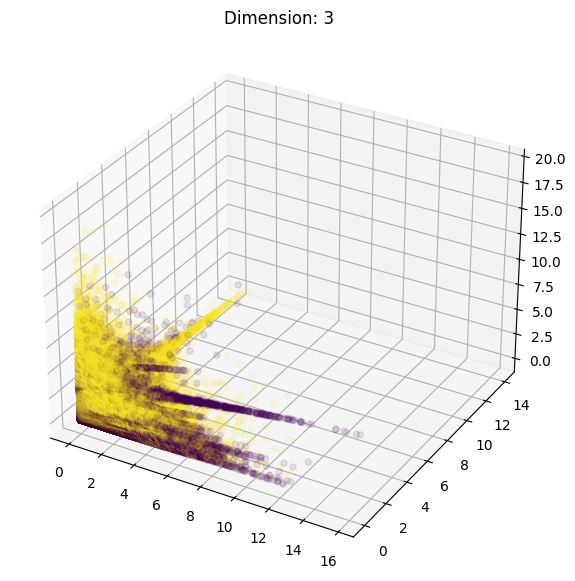

100%|█████████████████████████████████████████████| 1/1 [01:30<00:00, 90.45s/it]

time: 1min 30s (started: 2023-05-18 10:02:58 -05:00)


In [120]:
# Plot join
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

for dimension in tqdm(dimensions):
    # Read dataset
    df_edge_embeddings_join = pd.read_csv("{}/output_vgae/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, group[0], dimension, "L2"), index_col=0)

    x = df_edge_embeddings_join.iloc[:, 0]
    y = df_edge_embeddings_join.iloc[:, 1]
    z = df_edge_embeddings_join.iloc[:, 2]

    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    # Creating plot
    ax.scatter3D(x, y, z, c=df_edge_embeddings_join.iloc[:, -1], alpha=0.1)
    plt.title("Dimension: {}".format(dimension))

    # show plot
    plt.show()

### 5. Clustering

In [69]:
param_dist = { # No
    "min_samples": [10, 50, 100],
    "min_cluster_size":[100, 200, 300, 400, 500],  
    # "cluster_selection_method": ["eom", "leaf"],
    # "metric" : ["euclidean", "manhattan"]
}

min_cluster_sizes = [2, 4, 8, 16, 32, 64]
# dim. reduction: PCA, TSNE, UMAP

In [25]:
def cv_score(model, X): # No
    model.fit(X)
    labels = model.fit_predict(X)
    num_labels = len(list(labels))
    if num_labels == 1:
        # raise ValueError('number of labels must be greater than 2')
        print("Number of labels must be greater than 2")
    else:
        metric = silhouette_score(X, labels)
        # print("Metric: ", metric)
        return metric

time: 1.11 ms (started: 2023-05-12 09:31:21 -05:00)


In [ ]:
# Get best parameters (No)
from sklearn.model_selection import RandomizedSearchCV
import hdbscan

for dimension in tqdm(dimensions):
    df_edge_embeddings = pd.read_csv("{}/output_vgae/edge_embeddings_join/WT_edge-embeddings_join_{}_{}.csv".format(dir, dimension, "L2"), index_col=0)
    
    hdb = hdbscan.HDBSCAN()
    n_iter_search = 5
    random_search = RandomizedSearchCV(hdb, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=cv_score,
                                       n_jobs=8, random_state=42)

    random_search.fit(df_edge_embeddings.iloc[:, :-1])
    print("Best Parameters: ", random_search.best_params_)

In [19]:
# Get cluster (No)
for dimension in tqdm(dimensions):
    df_edge_embeddings = pd.read_csv("{}/output_vgae/edge_embeddings_join/WT_edge-embeddings_join_{}_{}.csv".format(dir, dimension, "L2"), index_col=0)
    
    X_train = df_edge_embeddings.iloc[:, [0, 1]]
    
    clustering = HDBSCAN(min_cluster_size=100, min_samples=100, core_dist_n_jobs=-1, 
                        allow_single_cluster=True)
    clustering.fit(df_edge_embeddings.iloc[:, :-1])
    X_train["labels"] = clustering.labels_

    # save
    X_train.to_csv("{}/output_vgae/cluster/WT_cluster_{}_{}.csv".format(dir, dimension, "L2"), index=True)


100%|████████████████████████████████████████| 1/1 [15:20<00:00, 920.77s/it]


In [ ]:
# silhouette_score(X_train.iloc[:, :-1], X_train.iloc[:, -1])

In [121]:
# Outlier detection

for dimension in tqdm(dimensions):
    df_edge_embeddings_join = pd.read_csv("{}/output_vgae/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, group[0], dimension, "L2"), index_col=0)
    
    X_train = df_edge_embeddings_join.iloc[:, :-1]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=100, core_dist_n_jobs=-1).fit(X_train)

100%|████████████████████████████████████████████| 1/1 [09:54<00:00, 594.64s/it]

time: 9min 54s (started: 2023-05-18 10:04:45 -05:00)


In [122]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

print(len(outliers))
outliers

604687


array([      0,       2,       3, ..., 6046817, 6046855, 6046856])

time: 11.8 s (started: 2023-05-18 10:20:52 -05:00)


6046865
604687
5285730


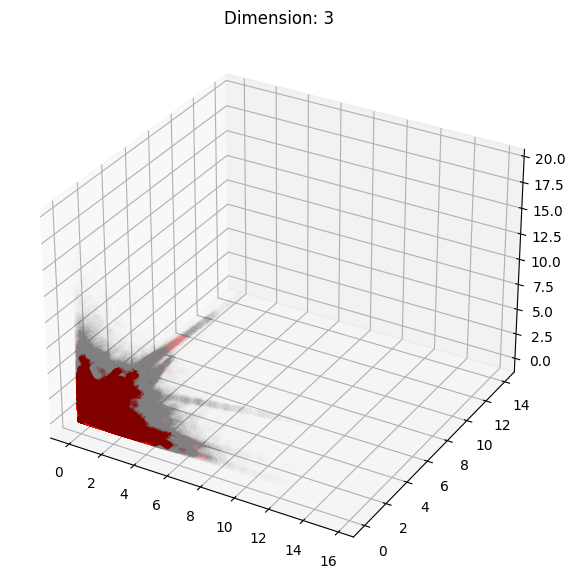

time: 1min 36s (started: 2023-05-18 10:21:10 -05:00)


In [123]:
print(len(df_edge_embeddings_join))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

temp = df_edge_embeddings_join.iloc[outliers, :]
x = temp.iloc[:, 0]
y = temp.iloc[:, 1]
z = temp.iloc[:, 2]
ax.scatter3D(x, y, z, c="gray", alpha=0.005)
print(len(temp))

temp = df_edge_embeddings_join.drop(df_edge_embeddings_join.index[outliers])
x = temp.iloc[:, 0]
y = temp.iloc[:, 1]
z = temp.iloc[:, 2]
ax.scatter3D(x, y, z, c="red", alpha=0.005)
print(len(temp))

plt.title("Dimension: {}".format(dimension))
plt.show()

##### Short test

In [159]:
h = np.array([0, 2, 3])

In [160]:
df = pd.DataFrame({'x':np.random.randn(6), 'y':np.random.randn(6)}, index=["a" ,"b", "c" ,"d", "e", "a"])
print(len(df))
df

6


,x,y
a,1.267958,-0.777996
b,0.367999,0.643993
c,-0.065813,-0.076241
d,-0.370284,0.677894
e,-0.123623,-0.542217
a,0.424043,-1.818676


In [163]:
df.index.value_counts()

a    2
b    1
c    1
d    1
e    1
Name: count, dtype: int64

In [161]:
e = df.iloc[h, :]
print(len(e))
e

3


,x,y
a,1.267958,-0.777996
c,-0.065813,-0.076241
d,-0.370284,0.677894


In [162]:
d = df.drop(df.index[h])
print(len(d))
d

2


,x,y
b,0.367999,0.643993
e,-0.123623,-0.542217


###  Filter common edges

In [124]:
df_edge_embeddings_join_filter = df_edge_embeddings_join.drop(df_edge_embeddings_join.index[outliers])
df_edge_embeddings_join_filter.to_csv("{}/output_vgae/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index=True)
df_edge_embeddings_join_filter

,0,1,2,subgroup
"(0, 2)",1.181895,0.000768,0.102486,1
"(0, 5)",0.974461,1.707977,0.401856,1
"(0, 10)",1.065851,0.056166,0.015172,1
"(0, 11)",1.344772,0.380666,0.039062,1
"(0, 15)",1.118951,0.003684,0.080726,1
...,...,...,...,...
"(6188, 6223)",0.032607,0.247013,0.021753,2
"(6195, 6196)",0.001485,0.002179,0.064413,2
"(6195, 6197)",0.042292,0.001780,0.000294,2
"(6196, 6197)",0.027927,0.007899,0.056005,2


time: 23.4 s (started: 2023-05-18 10:27:01 -05:00)


In [125]:
df_edge_embeddings_join_filter = pd.read_csv("{}/output_vgae/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index_col=0)
df_edge_embeddings_join_filter.set_index([pd.Index([eval(item) for item in df_edge_embeddings_join_filter.index])], inplace=True)
df_edge_embeddings_join_filter.to_csv("{}/output_vgae/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index=True)
df_edge_embeddings_join_filter

0         1         2  subgroup
0    2     1.181895  0.000768  0.102486         1
     5     0.974461  1.707977  0.401856         1
     10    1.065851  0.056166  0.015172         1
     11    1.344772  0.380666  0.039062         1
     15    1.118951  0.003684  0.080726         1
...             ...       ...       ...       ...
6188 6223  0.032607  0.247013  0.021753         2
6195 6196  0.001485  0.002179  0.064413         2
     6197  0.042292  0.001780  0.000294         2
6196 6197  0.027927  0.007899  0.056005         2
6197 6210  0.036191  0.048801  0.017252         2

[5285730 rows x 4 columns]

time: 54.2 s (started: 2023-05-18 10:27:28 -05:00)


In [126]:
df_edge_embeddings_join_filter = pd.read_csv("{}/output_vgae/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index_col=[0, 1])
df_edge_embeddings_join_filter

0         1         2  subgroup
0    2     1.181895  0.000768  0.102486         1
     5     0.974461  1.707977  0.401856         1
     10    1.065851  0.056166  0.015172         1
     11    1.344772  0.380666  0.039062         1
     15    1.118951  0.003684  0.080726         1
...             ...       ...       ...       ...
6188 6223  0.032607  0.247013  0.021753         2
6195 6196  0.001485  0.002179  0.064413         2
     6197  0.042292  0.001780  0.000294         2
6196 6197  0.027927  0.007899  0.056005         2
6197 6210  0.036191  0.048801  0.017252         2

[5285730 rows x 4 columns]

time: 2.02 s (started: 2023-05-18 10:28:33 -05:00)


In [127]:
df_nodes = pd.read_csv("{}/output_dgi/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], 1))
df_nodes

,idx,degree,ionMz
0,0,29,59.0049
1,1,114,99.9716
2,2,30,120.9310
3,3,106,172.0403
4,4,119,183.0464
...,...,...,...
6230,6230,2,901.7714
6231,6231,4,835.3027
6232,6232,5,835.3377
6233,6233,2,844.5313


time: 7.89 ms (started: 2023-05-18 10:28:38 -05:00)


In [128]:
# Mapping idx with ionMz
dict_df_nodes = {}
list_index = []
for i in tqdm(subgroups):
    df_nodes = pd.read_csv("{}/output_dgi/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], i))
    dict_df_nodes[i] = df_nodes

for dimension in tqdm(dimensions):
    df_edge_embeddings_join_filter = pd.read_csv("{}/output_vgae/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index_col=[0, 1])

    for row in df_edge_embeddings_join_filter.itertuples():
        df_nodes = dict_df_nodes[str(row[-1])]        
        list_index.append((df_nodes.iloc[row[0][0], -1], df_nodes.iloc[row[0][1], -1]))

100%|████████████████████████████████████████████| 1/1 [02:24<00:00, 144.06s/it]

time: 2min 25s (started: 2023-05-18 10:28:40 -05:00)


In [129]:
# Set new index
df_edge_embeddings_join_filter.set_index([pd.Index(list_index)], inplace=True)
df_edge_embeddings_join_filter

0         1         2  subgroup
59.0049  120.9310  1.181895  0.000768  0.102486         1
         192.0498  0.974461  1.707977  0.401856         1
         315.0359  1.065851  0.056166  0.015172         1
         359.8586  1.344772  0.380666  0.039062         1
         373.0599  1.118951  0.003684  0.080726         1
...                     ...       ...       ...       ...
717.2421 717.2314  0.032607  0.247013  0.021753         2
585.1060 654.4398  0.001485  0.002179  0.064413         2
         655.3718  0.042292  0.001780  0.000294         2
654.4398 655.3718  0.027927  0.007899  0.056005         2
655.3718 655.3228  0.036191  0.048801  0.017252         2

[5285730 rows x 4 columns]

time: 2.38 s (started: 2023-05-18 10:31:11 -05:00)


In [130]:
# Count
temp = df_edge_embeddings_join_filter.index.value_counts().to_frame()
df_edge_embeddings_join_filter_count = temp[temp["count"] == len(subgroups)]
df_edge_embeddings_join_filter_count.to_csv("{}/output_vgae/edges_filter/{}_edges-filter-count_{}_{}.csv".format(dir, group[0], dimension, "L2"), index=True)
df_edge_embeddings_join_filter_count

,,count
475.4061,700.4921,2
455.2667,813.4851,2
633.4728,877.6205,2
518.1538,744.2497,2
633.4728,878.4509,2
...,...,...
155.0654,260.1250,2
403.0724,867.5411,2
275.0653,559.1470,2
154.9474,239.9114,2


time: 1.66 s (started: 2023-05-18 10:31:16 -05:00)


In [131]:
df_edge_embeddings_join_filter_count = pd.read_csv("{}/output_vgae/edges_filter/{}_edges-filter-count_{}_{}.csv".format(dir, group[0], 3, "L2"))
df_edge_embeddings_join_filter_count.columns = ["source", "target", "count"]
# print(df_edge_embeddings_join_filter_count.info())
df_edge_embeddings_join_filter_count

,source,target,count
0,475.4061,700.4921,2
1,455.2667,813.4851,2
2,633.4728,877.6205,2
3,518.1538,744.2497,2
4,633.4728,878.4509,2
...,...,...,...
459481,155.0654,260.1250,2
459482,403.0724,867.5411,2
459483,275.0653,559.1470,2
459484,154.9474,239.9114,2


time: 70.2 ms (started: 2023-05-18 10:31:22 -05:00)


In [132]:
df_edges = pd.read_csv("{}/output_dgi/edges/{}_edges_{}.csv".format(dir, group[0], 2))
print(df_edges.info())
df_edges

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417355 entries, 0 to 4417354
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   source  float64
 1   target  float64
 2   weight  float64
dtypes: float64(3)
memory usage: 101.1 MB
None


,source,target,weight
0,59.0049,338.1873,0.507709
1,59.0049,357.2834,0.516811
2,59.0049,453.9675,0.507832
3,59.0049,587.1823,0.521553
4,59.0049,613.3933,0.516046
...,...,...,...
4417350,996.5509,997.5542,0.618624
4417351,996.5509,998.4845,0.678071
4417352,996.7096,997.5542,0.566913
4417353,997.5542,997.7131,0.589712


time: 1.13 s (started: 2023-05-18 10:31:25 -05:00)


In [133]:
# Get weight
df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
s = []
t = []
for row in df_edge_embeddings_join_filter_count_weight.itertuples():
    if row[1] > row[2]:
        s.append(row[2])
        t.append(row[1])
    else:
        s.append(row[1])
        t.append(row[2])
df_edge_embeddings_join_filter_count_weight["source"] = s
df_edge_embeddings_join_filter_count_weight["target"] = t

# df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
df_edge_embeddings_join_filter_count_weight.sort_values(["source", "target"], ascending=True, inplace=True)
df_edge_embeddings_join_filter_count_weight["idx"] = df_edge_embeddings_join_filter_count_weight["source"].astype(str) + "-" + df_edge_embeddings_join_filter_count_weight["target"].astype(str)
list_aux = df_edge_embeddings_join_filter_count_weight.iloc[:, -1].values

for i in tqdm(subgroups):
    df_edges = pd.read_csv("{}/output_dgi/edges/{}_edges_{}.csv".format(dir, group[0], i))
    df_edges.sort_values(["source", "target"], ascending=True, inplace=True)
    df_edges["idx"] = df_edges["source"].astype(str) + "-" + df_edges["target"].astype(str)

    """ list_temp = []
    # for j in tqdm(range(len(df_edges_filter_count_weight))):
    for row in tqdm(df_edge_embeddings_join_filter_count_weight.itertuples()):
        # weight = 1 # df_edges[(df_edges["source"] == row[1]) & (df_edges["target"] == row[2])].iloc[0, -1]
        weight = df_edges[df_edges["idx"] == "{}-{}".format(row[1], row[2])].iloc[0, -2]
        list_temp.append(weight) """
    
    filter = df_edges["idx"].isin(list_aux)
    temp = df_edges[filter]
    list_temp = temp.iloc[:, -2].values
    df_edge_embeddings_join_filter_count_weight["subgroup{}".format(i)] = list_temp
df_edge_embeddings_join_filter_count_weight


100%|█████████████████████████████████████████████| 2/2 [00:09<00:00,  4.88s/it]


,source,target,count,idx,subgroup1,subgroup2
454778,59.0137,61.9884,2,59.0137-61.9884,0.780303,0.588602
454980,59.0137,119.0540,2,59.0137-119.054,0.742808,0.661993
455029,59.0137,121.9970,2,59.0137-121.997,0.648936,0.711157
455027,59.0137,122.0247,2,59.0137-122.0247,0.702536,0.833275
454925,59.0137,125.0241,2,59.0137-125.0241,0.794793,0.796542
...,...,...,...,...,...,...
444338,984.3993,984.5048,2,984.3993-984.5048,0.678804,0.704638
458724,985.5490,988.4452,2,985.549-988.4452,0.567821,0.540976
450468,986.5138,986.5500,2,986.5138-986.55,0.768651,0.796162
445822,988.4452,988.5664,2,988.4452-988.5664,0.671791,0.761600


time: 10.7 s (started: 2023-05-18 10:31:32 -05:00)


In [134]:
df_edges = pd.read_csv("{}/output_dgi/edges/{}_edges_{}.csv".format(dir, group[0], 2))
df_edges[(df_edges["source"] == 74.0249) & (df_edges["target"] == 131.0462)].iloc[0, -1]

0.8954667810690092

time: 983 ms (started: 2023-05-18 10:31:48 -05:00)


In [135]:
# Dispersion (std)
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight.copy()
df_edge_embeddings_join_filter_count_weight_std["std"] = np.std(df_edge_embeddings_join_filter_count_weight_std.iloc[:, -len(subgroups):], axis=1)
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,std
454778,59.0137,61.9884,2,59.0137-61.9884,0.780303,0.588602,0.095850
454980,59.0137,119.0540,2,59.0137-119.054,0.742808,0.661993,0.040407
455029,59.0137,121.9970,2,59.0137-121.997,0.648936,0.711157,0.031111
455027,59.0137,122.0247,2,59.0137-122.0247,0.702536,0.833275,0.065369
454925,59.0137,125.0241,2,59.0137-125.0241,0.794793,0.796542,0.000874
...,...,...,...,...,...,...,...
444338,984.3993,984.5048,2,984.3993-984.5048,0.678804,0.704638,0.012917
458724,985.5490,988.4452,2,985.549-988.4452,0.567821,0.540976,0.013422
450468,986.5138,986.5500,2,986.5138-986.55,0.768651,0.796162,0.013755
445822,988.4452,988.5664,2,988.4452-988.5664,0.671791,0.761600,0.044904


time: 81.7 ms (started: 2023-05-18 10:31:53 -05:00)


In [136]:
# Filter by std
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight_std[df_edge_embeddings_join_filter_count_weight_std["std"] <= 0.3]
df_edge_embeddings_join_filter_count_weight_std.to_csv("{}/output_vgae/edges_filter_weight_std/{}_edge-filter-weight-std_{}_{}.csv".format(dir, group[0], dimension, "L2"), index=False)
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,std
454778,59.0137,61.9884,2,59.0137-61.9884,0.780303,0.588602,0.095850
454980,59.0137,119.0540,2,59.0137-119.054,0.742808,0.661993,0.040407
455029,59.0137,121.9970,2,59.0137-121.997,0.648936,0.711157,0.031111
455027,59.0137,122.0247,2,59.0137-122.0247,0.702536,0.833275,0.065369
454925,59.0137,125.0241,2,59.0137-125.0241,0.794793,0.796542,0.000874
...,...,...,...,...,...,...,...
444338,984.3993,984.5048,2,984.3993-984.5048,0.678804,0.704638,0.012917
458724,985.5490,988.4452,2,985.549-988.4452,0.567821,0.540976,0.013422
450468,986.5138,986.5500,2,986.5138-986.55,0.768651,0.796162,0.013755
445822,988.4452,988.5664,2,988.4452-988.5664,0.671791,0.761600,0.044904


time: 2.08 s (started: 2023-05-18 10:31:56 -05:00)


In [137]:
df_edge_embeddings_join_filter_count_weight_std = pd.read_csv("{}/output_vgae/edges_filter_weight_std/{}_edge-filter-weight-std_{}_{}.csv".format(dir, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,std
0,59.0137,61.9884,2,59.0137-61.9884,0.780303,0.588602,0.095850
1,59.0137,119.0540,2,59.0137-119.054,0.742808,0.661993,0.040407
2,59.0137,121.9970,2,59.0137-121.997,0.648936,0.711157,0.031111
3,59.0137,122.0247,2,59.0137-122.0247,0.702536,0.833275,0.065369
4,59.0137,125.0241,2,59.0137-125.0241,0.794793,0.796542,0.000874
...,...,...,...,...,...,...,...
406813,984.3993,984.5048,2,984.3993-984.5048,0.678804,0.704638,0.012917
406814,985.5490,988.4452,2,985.549-988.4452,0.567821,0.540976,0.013422
406815,986.5138,986.5500,2,986.5138-986.55,0.768651,0.796162,0.013755
406816,988.4452,988.5664,2,988.4452-988.5664,0.671791,0.761600,0.044904


time: 356 ms (started: 2023-05-18 10:32:02 -05:00)


In [138]:
# Average weight
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std.copy()
df_edge_embeddings_join_filter_count_weight_std_avg["weight"] = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, -(len(subgroups) + 1):-1].mean(axis=1)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,count,idx,subgroup1,subgroup2,std,weight
0,59.0137,61.9884,2,59.0137-61.9884,0.780303,0.588602,0.095850,0.684453
1,59.0137,119.0540,2,59.0137-119.054,0.742808,0.661993,0.040407,0.702401
2,59.0137,121.9970,2,59.0137-121.997,0.648936,0.711157,0.031111,0.680047
3,59.0137,122.0247,2,59.0137-122.0247,0.702536,0.833275,0.065369,0.767906
4,59.0137,125.0241,2,59.0137-125.0241,0.794793,0.796542,0.000874,0.795668
...,...,...,...,...,...,...,...,...
406813,984.3993,984.5048,2,984.3993-984.5048,0.678804,0.704638,0.012917,0.691721
406814,985.5490,988.4452,2,985.549-988.4452,0.567821,0.540976,0.013422,0.554399
406815,986.5138,986.5500,2,986.5138-986.55,0.768651,0.796162,0.013755,0.782406
406816,988.4452,988.5664,2,988.4452-988.5664,0.671791,0.761600,0.044904,0.716696


time: 53.9 ms (started: 2023-05-18 10:32:05 -05:00)


In [139]:
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, [0, 1, -1]]
df_edge_embeddings_join_filter_count_weight_std_avg.to_csv("{}/output_vgae/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, group[0], dimension, "L2"), index=False)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,59.0137,61.9884,0.684453
1,59.0137,119.0540,0.702401
2,59.0137,121.9970,0.680047
3,59.0137,122.0247,0.767906
4,59.0137,125.0241,0.795668
...,...,...,...
406813,984.3993,984.5048,0.691721
406814,985.5490,988.4452,0.554399
406815,986.5138,986.5500,0.782406
406816,988.4452,988.5664,0.716696


time: 1.02 s (started: 2023-05-18 10:32:09 -05:00)


In [140]:
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_vgae/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,59.0137,61.9884,0.684453
1,59.0137,119.0540,0.702401
2,59.0137,121.9970,0.680047
3,59.0137,122.0247,0.767906
4,59.0137,125.0241,0.795668
...,...,...,...
406813,984.3993,984.5048,0.691721
406814,985.5490,988.4452,0.554399
406815,986.5138,986.5500,0.782406
406816,988.4452,988.5664,0.716696


time: 116 ms (started: 2023-05-18 10:32:13 -05:00)


---

### Change detection (Greedy algorithm)

In [9]:
import matplotlib.pyplot as plt

def info_graph(G):
    print("Num. nodes: {}".format(G.number_of_nodes()))
    print("Num. edges: {}".format(G.number_of_edges()))
    print()

time: 413 µs (started: 2023-05-15 12:52:09 -05:00)


#### Read edges

In [10]:
df_edges1 = pd.read_csv("{}/output_vgae/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, "WT", 3, "L2"))
df_edges1[["source", "target"]] = df_edges1[["source", "target"]].astype(str)
df_edges1

,source,target,weight
0,59.0137,389.3284,0.791692
1,59.0137,391.2964,0.826840
2,59.0137,418.3254,0.877965
3,59.0137,419.3285,0.790765
4,59.0291,391.2964,0.701323
...,...,...,...
11196,952.6839,954.6629,0.694432
11197,953.6866,978.5819,0.676104
11198,969.6816,972.471,0.803943
11199,969.6816,979.5239,0.856486


time: 52.5 ms (started: 2023-05-15 12:52:09 -05:00)


In [11]:
G1 = nx.from_pandas_edgelist(df_edges1, "source", "target", edge_attr=["weight"])

time: 22.2 ms (started: 2023-05-15 12:52:09 -05:00)


In [12]:
# nx.draw_networkx(G1, pos=nx.spring_layout(G1), font_size=8, font_color="black")

time: 394 µs (started: 2023-05-15 12:52:09 -05:00)


In [13]:
df_edges2 = pd.read_csv("{}/output_vgae/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, "zwf1^", 3, "L2"))
df_edges2[["source", "target"]] = df_edges2[["source", "target"]].astype(str)
df_edges2

,source,target,weight
0,59.0137,124.0403,0.770148
1,59.0137,133.0501,0.786825
2,59.0137,134.0473,0.863013
3,59.0137,141.0173,0.806392
4,59.0137,145.0984,0.790925
...,...,...,...
360657,981.5305,986.7752,0.738430
360658,984.759,985.549,0.688567
360659,984.759,988.5664,0.626375
360660,985.549,985.7644,0.648868


time: 431 ms (started: 2023-05-15 12:52:10 -05:00)


In [14]:
G2 = nx.from_pandas_edgelist(df_edges2, "source", "target", edge_attr=["weight"])

time: 627 ms (started: 2023-05-15 12:52:10 -05:00)


In [15]:
# nx.draw_networkx(G2, pos=nx.spring_layout(G2), font_size=8, font_color="black")

time: 454 µs (started: 2023-05-15 12:52:11 -05:00)


In [16]:
df_edges3 = pd.read_csv("{}/output_vgae/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, "pck1^", 3, "L2"))
df_edges3[["source", "target"]] = df_edges3[["source", "target"]].astype(str)
df_edges3

,source,target,weight
0,59.0137,74.0249,0.687070
1,59.0137,78.9592,0.672116
2,59.0137,96.9602,0.737447
3,59.0137,96.9688,0.753535
4,59.0137,101.0243,0.604324
...,...,...,...
414415,984.759,987.7787,0.627558
414416,985.7644,987.7787,0.528384
414417,986.7752,989.4484,0.597816
414418,987.5639,990.5673,0.699829


time: 498 ms (started: 2023-05-15 12:52:11 -05:00)


In [17]:
G3 = nx.from_pandas_edgelist(df_edges3, "source", "target", edge_attr=["weight"])

time: 733 ms (started: 2023-05-15 12:52:12 -05:00)


#### Get common nodes

In [18]:
nodes1 = set(list(G1.nodes()))
# print(nodes1)

nodes2 = set(list(G2.nodes()))
# print(nodes2)

common_nodes = list(nodes1 & nodes2)
print("Length of common nodes:", len(common_nodes))

Length of common nodes: 1674
time: 1.85 ms (started: 2023-05-15 12:52:13 -05:00)


#### Get subgraphs

In [19]:
H1 = G1.subgraph(common_nodes)
H2 = G2.subgraph(common_nodes)

time: 2.34 ms (started: 2023-05-15 12:52:13 -05:00)


In [20]:
# nx.draw_networkx(H1, pos=nx.spring_layout(H1), font_color="w")

time: 398 µs (started: 2023-05-15 12:52:13 -05:00)


In [21]:
# nx.draw_networkx(H2, pos=nx.spring_layout(H2), font_color="w")

time: 403 µs (started: 2023-05-15 12:52:13 -05:00)


Get changes

In [22]:
def sort_edges(edges):
    edges = list(edges)
    for k in range(len(edges)):
        if edges[k][0] > edges[k][1]:
            edges[k] = (edges[k][1], edges[k][0])
    return edges

def degree_distibution(graps, labels=[]):
    list_hist = []
    for graph in graps:
        list_hist.append(list(dict(graph.degree()).values()))
    
    plt.hist(list_hist, label=labels)
    plt.legend(loc='upper center')

    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

time: 1.16 ms (started: 2023-05-15 12:52:13 -05:00)


In [23]:
edges1 = set(sort_edges(H1.edges()))
edges2 = set(sort_edges(H2.edges()))

# print(edges1)
# print(edges2)

e1_inte_e2 = edges1 & edges2
print(len(e1_inte_e2))
# print(list(e1_inte_e2))

e1_diff_e2 = edges1 - edges2
print(len(e1_diff_e2))
# print(list(e1_diff_e2))

e2_diff_e1 = edges2 - edges1
print(len(e2_diff_e1))
# print(list(e2_diff_e1))

2235
8485
106279
time: 501 ms (started: 2023-05-15 12:52:13 -05:00)


In [24]:
df_subgraphs = pd.DataFrame(e1_inte_e2, columns=["source", "target"])
df_subgraphs

,source,target
0,264.9055,358.8579
1,162.056,628.0561
2,633.4328,813.4851
3,689.4951,877.5208
4,688.4907,759.5518
...,...,...
2230,820.5671,901.5947
2231,267.0965,517.1517
2232,255.2332,714.4689
2233,306.1101,506.1877


time: 12.6 ms (started: 2023-05-15 12:52:14 -05:00)


In [25]:
df_subgraphs["weight1"] = df_subgraphs.apply(lambda x: H1.get_edge_data(x.source, x.target)["weight"], axis=1)
df_subgraphs["weight2"] = df_subgraphs.apply(lambda x: H2.get_edge_data(x.source, x.target)["weight"], axis=1)
df_subgraphs

,source,target,weight1,weight2
0,264.9055,358.8579,0.702577,0.888251
1,162.056,628.0561,0.785290,0.627830
2,633.4328,813.4851,0.850005,0.778677
3,689.4951,877.5208,0.738469,0.751602
4,688.4907,759.5518,0.810682,0.641725
...,...,...,...,...
2230,820.5671,901.5947,0.741332,0.674779
2231,267.0965,517.1517,0.713350,0.689213
2232,255.2332,714.4689,0.723103,0.794158
2233,306.1101,506.1877,0.818823,0.878159


time: 81.9 ms (started: 2023-05-15 12:52:14 -05:00)


In [26]:
list_subgraphs = []
for edge in e1_diff_e2:
    list_subgraphs.append([edge[0], edge[1], H1.get_edge_data(edge[0], edge[1])["weight"], np.nan])

for edge in e2_diff_e1:
    list_subgraphs.append([edge[0], edge[1], np.nan, H2.get_edge_data(edge[0], edge[1])["weight"]])

df_temp = pd.DataFrame(list_subgraphs, columns=["source", "target", "weight1", "weight2"])
df_subgraphs = pd.concat([df_subgraphs, df_temp])
df_subgraphs

,source,target,weight1,weight2
0,264.9055,358.8579,0.702577,0.888251
1,162.056,628.0561,0.785290,0.627830
2,633.4328,813.4851,0.850005,0.778677
3,689.4951,877.5208,0.738469,0.751602
4,688.4907,759.5518,0.810682,0.641725
...,...,...,...,...
114759,330.0704,505.1609,NaN,0.716583
114760,278.1847,980.0155,NaN,0.777074
114761,263.0973,798.0267,NaN,0.654707
114762,604.3977,686.4762,NaN,0.658939


time: 584 ms (started: 2023-05-15 12:52:14 -05:00)


In [27]:
df_subgraphs["difference"] = df_subgraphs["weight1"] - df_subgraphs["weight2"]
df_subgraphs["difference"] = df_subgraphs["difference"].abs()
df_subgraphs

,source,target,weight1,weight2,difference
0,264.9055,358.8579,0.702577,0.888251,0.185674
1,162.056,628.0561,0.785290,0.627830,0.157460
2,633.4328,813.4851,0.850005,0.778677,0.071328
3,689.4951,877.5208,0.738469,0.751602,0.013133
4,688.4907,759.5518,0.810682,0.641725,0.168957
...,...,...,...,...,...
114759,330.0704,505.1609,NaN,0.716583,NaN
114760,278.1847,980.0155,NaN,0.777074,NaN
114761,263.0973,798.0267,NaN,0.654707,NaN
114762,604.3977,686.4762,NaN,0.658939,NaN


time: 17.8 ms (started: 2023-05-15 12:52:15 -05:00)


In [28]:
# Add labels for correlaction changes
threshold2 = 0.8
conditions = [
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"].isnull()) & (df_subgraphs["weight1"] >= threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"].isnull()) & (df_subgraphs["weight1"] < threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"].isnull()) & (df_subgraphs["weight1"] >= threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"].isnull()) & (df_subgraphs["weight1"] < threshold2)),

    ((df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"].isnull()) & (df_subgraphs["weight2"] >= threshold2)),
    ((df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"].isnull()) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"].isnull()) & (df_subgraphs["weight2"] >= threshold2)),
    ((df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"].isnull()) & (df_subgraphs["weight2"] < threshold2)),

    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] > -threshold2) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] > -threshold2) & (df_subgraphs["weight2"] >= threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] <= -threshold2) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] <= -threshold2) & (df_subgraphs["weight2"] >= threshold2)),

    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] < threshold2) & (df_subgraphs["weight2"] > -threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] >= threshold2) & (df_subgraphs["weight2"] > -threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] < threshold2) & (df_subgraphs["weight2"] <= -threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] >= threshold2) & (df_subgraphs["weight2"] <= -threshold2)),

    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] >= threshold2) & (df_subgraphs["weight2"] >= threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] < threshold2) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] >= threshold2) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] < threshold2) & (df_subgraphs["weight2"] >= threshold2)),

    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] <= -threshold2) & (df_subgraphs["weight2"] <= -threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] > -threshold2) & (df_subgraphs["weight2"] > -threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] <= -threshold2) & (df_subgraphs["weight2"] > -threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] > -threshold2) & (df_subgraphs["weight2"] <= -threshold2)),
]
# print(conditions)

values = ["N?", "n?", "P?", "p?", "?N", "?n", "?P", "?p", "np", "nP", "Np", "NP", "pn", "Pn", "pN", "PN", "PP", "pp", "Pp", "pP", "NN", "nn", "Nn", "nN"]
df_subgraphs["change"] = np.select(conditions, values)
df_subgraphs.to_csv("{}/output_vgae/subgraphs/{}_{}_subgraphs_{}_{}.csv".format(dir, "WT", "zwf1^", 3, "L2"), index=False)

df_subgraphs

,source,target,weight1,weight2,difference,change
0,264.9055,358.8579,0.702577,0.888251,0.185674,pP
1,162.056,628.0561,0.785290,0.627830,0.157460,pp
2,633.4328,813.4851,0.850005,0.778677,0.071328,Pp
3,689.4951,877.5208,0.738469,0.751602,0.013133,pp
4,688.4907,759.5518,0.810682,0.641725,0.168957,Pp
...,...,...,...,...,...,...
114759,330.0704,505.1609,NaN,0.716583,NaN,?p
114760,278.1847,980.0155,NaN,0.777074,NaN,?p
114761,263.0973,798.0267,NaN,0.654707,NaN,?p
114762,604.3977,686.4762,NaN,0.658939,NaN,?p


time: 350 ms (started: 2023-05-15 12:52:15 -05:00)


In [29]:
df_subgraphs = pd.read_csv("{}/output_vgae/subgraphs/{}_{}_subgraphs_{}_{}.csv".format(dir, "WT", "zwf1^", 3, "L2"))
df_subgraphs

,source,target,weight1,weight2,difference,change
0,264.9055,358.8579,0.702577,0.888251,0.185674,pP
1,162.0560,628.0561,0.785290,0.627830,0.157460,pp
2,633.4328,813.4851,0.850005,0.778677,0.071328,Pp
3,689.4951,877.5208,0.738469,0.751602,0.013133,pp
4,688.4907,759.5518,0.810682,0.641725,0.168957,Pp
...,...,...,...,...,...,...
116994,330.0704,505.1609,NaN,0.716583,NaN,?p
116995,278.1847,980.0155,NaN,0.777074,NaN,?p
116996,263.0973,798.0267,NaN,0.654707,NaN,?p
116997,604.3977,686.4762,NaN,0.658939,NaN,?p


time: 77.4 ms (started: 2023-05-15 12:52:15 -05:00)


In [30]:
H = nx.from_pandas_edgelist(df_subgraphs, "source", "target", edge_attr=["change"], create_using=nx.DiGraph())
H.edges(data=True)

print("WT")
info_graph(G1)

print("zwf1")
info_graph(G2)

print("pck1")
info_graph(G3)

print("Subgraph")
info_graph(H)

WT
Num. nodes: 1778
Num. edges: 11201

zwf1
Num. nodes: 4624
Num. edges: 360662

pck1
Num. nodes: 5089
Num. edges: 414420

Subgraph
Num. nodes: 1667
Num. edges: 116999

time: 267 ms (started: 2023-05-15 12:52:16 -05:00)


In [31]:
# nx.draw_networkx(H, pos=nx.spring_layout(H), font_color="w")

time: 388 µs (started: 2023-05-15 12:52:16 -05:00)


In [32]:
# degree_distibution([G1, G2, H], ["G1", "G2", "H"])

time: 199 µs (started: 2023-05-15 12:52:16 -05:00)


In [33]:
# sorted(H.degree, key=lambda x: x[1], reverse=True)

time: 371 µs (started: 2023-05-15 12:52:16 -05:00)


#### Filter and plot

{(356.103, 877.6205): Text(0.24999998137354879, 0.4330127121725851, '?P'),
 (356.103, 863.5636): Text(0.7499999590218074, -0.43301269296576733, '?p'),
 (587.3821, 863.5636): Text(0.4999999478459366, 2.4504569873240456e-08, 'PP'),
 (587.3821, 877.6205): Text(-2.9802321943606103e-08, 0.8660254296429223, '?p'),
 (283.3108,
  877.6205): Text(-0.49999996274709757, -5.297752070365647e-09, 'Pp'),
 (283.3108, 863.5636): Text(1.4901160971803051e-08, -0.8660254104361045, '?P'),
 (863.5636,
  877.6205): Text(-5.9604643887212205e-08, -5.297752070365647e-09, '?P')}

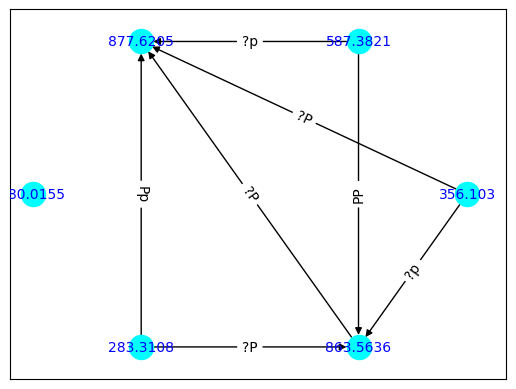

time: 202 ms (started: 2023-05-15 12:52:55 -05:00)


In [36]:
HF = H.subgraph([283.3108, 877.6205, 587.3821, 863.5636, 356.103, 980.0155])
edge_labels = nx.get_edge_attributes(HF, "change")

pos = pos=nx.circular_layout(HF)
nx.draw_networkx(HF, pos, font_color="blue", font_size=10, node_color="cyan")
nx.draw_networkx_edge_labels(H, pos, edge_labels)